### SPEECH TRANSLATION


This Project includes implementation of Encoder-Decoder model and implementation of RNN

**Encoder-Decoder (encoding-decoding) is a very common model framework in deep learning. For example, auto-encoding of unsupervised algorithms is designed and trained with the structure of encoding-decoding; Is the encoding-decoding framework of CNN-RNN; for example, the neural network machine translation NMT model is often the LSTM-LSTM encoding-decoding framework.**

Therefore, to be precise, Encoder-Decoder is not a specific model, but a kind of framework. Encoder and Decoder parts can be any text, voice, image, video data, and models can use CNN, RNN, BiRNN, LSTM, GRU, etc. So based on Encoder-Decoder, we can design a variety of application algorithms.

Here we have made use of **voice**

One of the most significant features of the Encoder-Decoder framework is that it is an End-to-End learning algorithm. Such models are often used in machine translation, such as translating one language to another . Such a model is also called Sequence to Sequence learning. The so-called encoding is to convert the input sequence into a fixed-length vector and decoding is to convert the previously generated fixed vector into an output sequence.

### Python libraries used for this project - 
    - librosa            - for audio processing
    - os                 - for operating system files
    - numpy              - for numerical analysis
    - matplotlib         - for data visualization
    - scipy              - for wavfile handling
    - speech_recognition - for translating speech to text
    - pydub              - working with wav files
    - tensorflow         - machine learning library
    - keras              - neural network library(runs on top of tensorflow)

In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore") 
from __future__ import print_function
from gtts import gTTS

from keras.models import Model
from keras.layers import Input, LSTM, Dense

**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way. 

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

In [2]:
train_audio_path = './OSR_UK.wav'
#train_audio_path = './OSR_boy.wav'
samples, sample_rate = librosa.load(train_audio_path)
print(f"Samples for the loaded data is:{samples}\n")
print(f"Sample rate for the loaded data is:{sample_rate}")

Samples for the loaded data is:[0.00709834 0.0094994  0.01068827 ... 0.0182565  0.01280983 0.00607053]

Sample rate for the loaded data is:22050


In [3]:
ipd.Audio(samples, rate=sample_rate)

### SPECTOGRAM

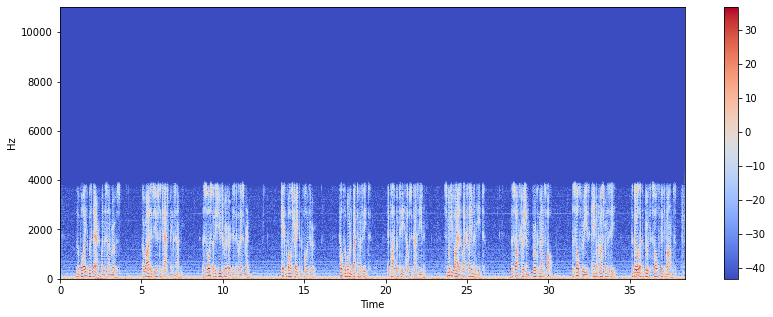

In [4]:
import librosa.display
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

### The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip.

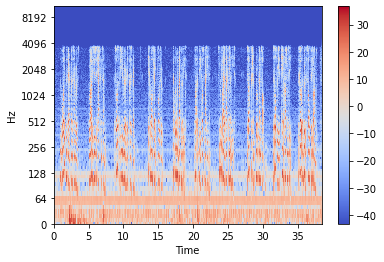

In [5]:
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

## Feature-Extraction - Zero-Crossing Rate

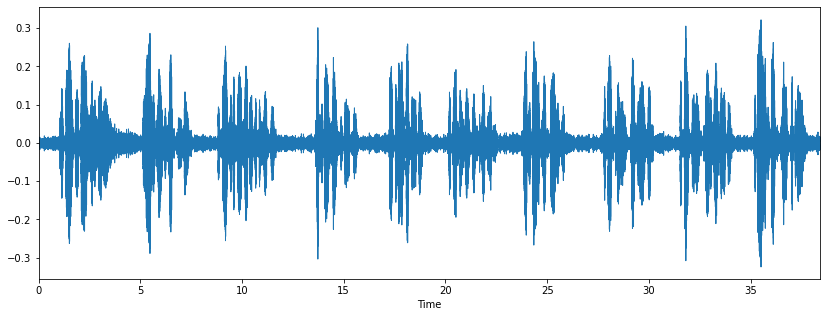

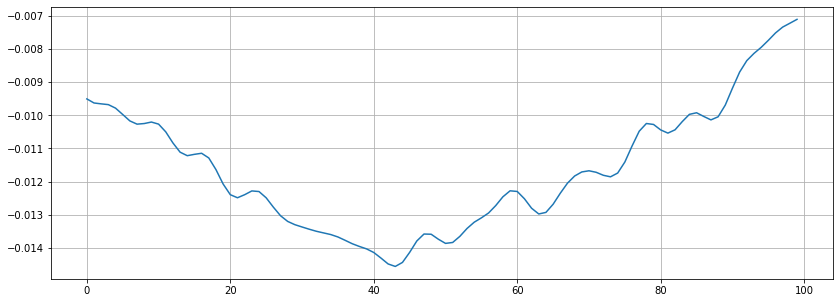

In [6]:
train_audio_path = './OSR_UK.wav'
x, sr = librosa.load(train_audio_path,sr=sample_rate)

#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [7]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print("Total Zero crossings:",sum(zero_crossings))

Total Zero crossings: 0


### Mel-Frequency Cepstral Coefficients(MFCCs)

(20, 1654)


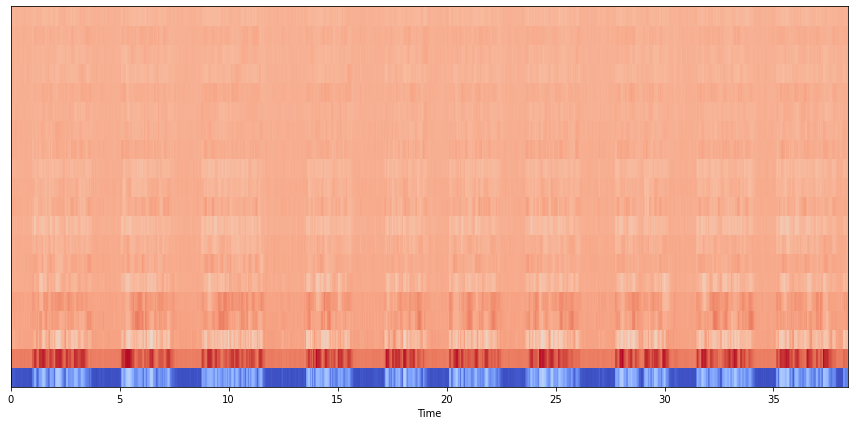

In [8]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [9]:
# load wave file
wav, _ = librosa.load(train_audio_path, mono=True, sr=16000)
# get mfcc feature
mfcc = np.transpose(np.expand_dims(librosa.feature.mfcc(wav, 16000), axis=0), [0, 2, 1])

In [10]:
print(f"MFCC : {mfcc}")

MFCC : [[[-5.06527893e+02  9.48223572e+01  2.25626831e+01 ...  2.92929721e+00
    4.93677807e+00  9.37672997e+00]
  [-5.02110107e+02  1.00512939e+02  2.27365685e+01 ...  3.35719180e+00
    2.24056435e+00  7.66504145e+00]
  [-4.98850952e+02  1.02090202e+02  1.90084858e+01 ... -2.73532510e-01
   -5.92092752e-01  9.37241554e+00]
  ...
  [-4.17551727e+02  1.11699135e+02 -2.46902618e+01 ...  6.95903444e+00
   -3.84964705e+00  8.84502316e+00]
  [-4.12577759e+02  1.05691765e+02 -2.59780922e+01 ...  8.14393902e+00
    9.25991058e-01  5.70220184e+00]
  [-4.15764465e+02  8.76333313e+01 -1.31009417e+01 ...  8.16631794e+00
    2.87764692e+00 -1.52453676e-01]]]


### Step of Conversion of Speech to text

In [11]:
from pydub import AudioSegment 
import speech_recognition as sr

'''Input audio file to be sliced''' 

audio = AudioSegment.from_wav("./OSR_UK.wav")
#audio = AudioSegment.from_wav("./OSR_boy.wav")

''' 
Step #1 - Now we will be slicing the audio file into chunks of smaller parts
'''
# Length of the audiofile in milliseconds 
n = len(audio)

print(f"Length of audio :{n}")

'''Variable to count the number of sliced chunks'''  

counter = 1

'''Text file to write the recognized audio''' 

fh = open("recognized.txt", "w+")

'''
Interval length at which to slice the audio file. 
# If length is 22 seconds, and interval is 5 seconds, 
# The chunks created will be: 
# chunk1 : 0 - 5 seconds 
# chunk2 : 5 - 10 seconds 
# chunk3 : 10 - 15 seconds 
# chunk4 : 15 - 20 seconds 
# chunk5 : 20 - 22 seconds '''

interval = 5 * 1000
overlap = 1.5 * 1000

'''Initialize start and end seconds to 0''' 
start = 0
end = 0

'''
Flag to keep track of end of file. 
When audio reaches its end, flag is set to 1 and we break the loop
'''
flag = 0

'''Iterating'''

for i in range(0, 2 * n, interval):
    if i == 0: 
        start = 0
        end = interval
    else: 
        start = end - overlap 
        end = start + interval
    if end >= n: 
        end = n 
        flag = 1
    chunk = audio[start:end]
    filename = 'chunk'+str(counter)+'.wav'
    chunk.export(filename, format ="wav")
    print("Processing chunk "+str(counter)+". Start = " +str(start)+" end = "+str(end))
    counter = counter + 1
    AUDIO_FILE = filename
    
    '''Initialize the recognizer'''
    r = sr.Recognizer()
    with sr.AudioFile(AUDIO_FILE) as source: 
        audio_listened = r.listen(source)
    try:     
        rec = r.recognize_google(audio_listened)
        fh.write(rec+" ")
    except sr.UnknownValueError: 
        print("Could not understand audio")
    except sr.RequestError as e: 
        print("Could not request results.")
    if flag == 1: 
        fh.close() 
        break

Length of audio :38400
Processing chunk 1. Start = 0 end = 5000
Processing chunk 2. Start = 3500.0 end = 8500.0
Processing chunk 3. Start = 7000.0 end = 12000.0
Processing chunk 4. Start = 10500.0 end = 15500.0
Processing chunk 5. Start = 14000.0 end = 19000.0
Processing chunk 6. Start = 17500.0 end = 22500.0
Processing chunk 7. Start = 21000.0 end = 26000.0
Processing chunk 8. Start = 24500.0 end = 29500.0
Processing chunk 9. Start = 28000.0 end = 33000.0
Processing chunk 10. Start = 31500.0 end = 36500.0
Processing chunk 11. Start = 35000.0 end = 38400


In [12]:
def read_data():
    with open('./recognized.txt', 'r') as file:
        data = file.read()
        print(f" Data after conversion from speech to text is : \n {data}")
read_data()

 Data after conversion from speech to text is : 
 the boy was there when the sun was what is used to catch pink some the source of the shoes repair is the closest friend is the closest friend for straight to help the women back to the sea that you have received a part of it helps to test it Nokia fire let's play min slim in heat question show so customer see the girl at the Bruce the core attributes salt 50 lbs 


### SEQUENCE 2 SEQUENCE MODEL

In [178]:
batch_s = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dimension = 256  # Latent dimensionality of the encoding space.
number_samples = 12  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './OSR.txt'

In [179]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(number_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [180]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 11
Number of unique input tokens: 31
Number of unique output tokens: 51
Max sequence length for inputs: 49
Max sequence length for outputs: 68


In [181]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [182]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [183]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index['\t']] = 1.
    decoder_target_data[i, t:, target_token_index['\t']] = 1.

In [184]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dimension, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [185]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dimension, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [186]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [192]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_s,
          epochs=epochs,
          validation_split=0.40)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.1483 - accuracy: 0.6373 - val_loss: 2.6764 - val_accuracy: 0.4500
Epoch 2/200
1/1 [==============================] - 0s 93ms/step - loss: 2.1032 - accuracy: 0.4608 - val_loss: 1.9715 - val_accuracy: 0.5324
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 1.6226 - accuracy: 0.5809 - val_loss: 1.9241 - val_accuracy: 0.5529
Epoch 4/200
1/1 [==============================] - 0s 85ms/step - loss: 1.3313 - accuracy: 0.6397 - val_loss: 1.8985 - val_accuracy: 0.5706
Epoch 5/200
1/1 [==============================] - 0s 101ms/step - loss: 1.2683 - accuracy: 0.6936 - val_loss: 2.0377 - val_accuracy: 0.5618
Epoch 6/200
1/1 [==============================] - 0s 76ms/step - loss: 1.2579 - accuracy: 0.6324 - val_loss: 1.9191 - val_accuracy: 0.5500
Epoch 7/200
1/1 [==============================] - 0s 72ms/step - loss: 1.3226 - accuracy: 0.6740 - val_loss: 1.9859 - val_accuracy: 0.5441
Epoch 8/200
1/1 [====

Epoch 117/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2199 - accuracy: 0.9902 - val_loss: 2.6546 - val_accuracy: 0.5500
Epoch 118/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2183 - accuracy: 0.9828 - val_loss: 2.5955 - val_accuracy: 0.5529
Epoch 119/200
1/1 [==============================] - 0s 100ms/step - loss: 0.2386 - accuracy: 0.9804 - val_loss: 2.6945 - val_accuracy: 0.5441
Epoch 120/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2345 - accuracy: 0.9657 - val_loss: 2.5887 - val_accuracy: 0.5412
Epoch 121/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2629 - accuracy: 0.9681 - val_loss: 2.6717 - val_accuracy: 0.5471
Epoch 122/200
1/1 [==============================] - 0s 102ms/step - loss: 0.2501 - accuracy: 0.9657 - val_loss: 2.7073 - val_accuracy: 0.5618
Epoch 123/200
1/1 [==============================] - 0s 109ms/step - loss: 0.2580 - accuracy: 0.9657 - val_loss: 2.5908 - val_accuracy: 0.5294
Epo

In [193]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dimension,))
decoder_state_input_c = Input(shape=(latent_dimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [194]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [195]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [196]:
for seq_index in range(11):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    try:
        decoded_sentence = decode_sequence(input_seq)
    except:
        print(f"Data cannot be inserted")
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: The boy was there when the sun rose.
Decoded sentence: सूरज उगने पर लड़का वहीं था।

-
Input sentence: A rod is used to catch pink salmon.
Decoded sentence: गुलाबी सामन को पकड़ने के लिए एक छड़ का उपयोग किया जाता है।

-
Input sentence: The source of the huge river is the clear spring.
Decoded sentence: विशाल नदी का स्रोत स्पष्ट वसंत है।

-
Input sentence: Kick the ball straight and follow through.
Decoded sentence: गेंद को सीधा मारें और फॉलो करें।

-
Input sentence: Kick the ball straight and follow through.
Decoded sentence: गेंद को सीधा मारें और फॉलो करें।

-
Input sentence: Help the woman get back to her feet.
Decoded sentence: गुलाबी सामन को पकड़ने के लिए एक छड़ का उपयोग किया जाता है।

-
Input sentence: A pot of tea helps to pass the evening.
Decoded sentence: गुलाबी सामन को पकड़ने के लिए एक छड़ का उपयोग किया जाता है।

-
Input sentence: Smoky fires lack flame and heat.
Decoded sentence: गेंद को सीधा मारें और फॉलो करें।

-
Input sentence: The soft cushion broke the m

### SPEECH GENERATION

In [3]:
# The text that you want to convert to audio 
mytext = 'सूरज उगने पर लड़का वहीं था। गुलाबी सामन को पकड़ने के लिए एक छड़ का उपयोग किया जाता है। विशाल नदी का स्रोत स्पष्ट वसंत है।'
  
# Language in which you want to convert 
language = 'hi'
  
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
obj = gTTS(text=mytext, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# eng-hin.mp3  
obj.save("eng-hin.wav") 
  
# Playing the converted file 
txt2spch = './eng-hin.wav'
ipd.Audio(txt2spch)